In [1]:
# maksimalkan threads
import os
os.environ['OMP_NUM_THREADS'] = '12'

In [2]:
# load dataset
import pandas as pd
import seaborn as sns

df = sns.load_dataset('titanic')

# EDA
print('5 data teratas')
df.head()

print('cek info dataset')
print(df.info(), '\n')

print('cek missing values')
print(df.isnull().sum(), '\n')

print('cek missing values')
print(df.isnull().sum().sum())

5 data teratas
cek info dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None 

cek missing values
survived         0
pc

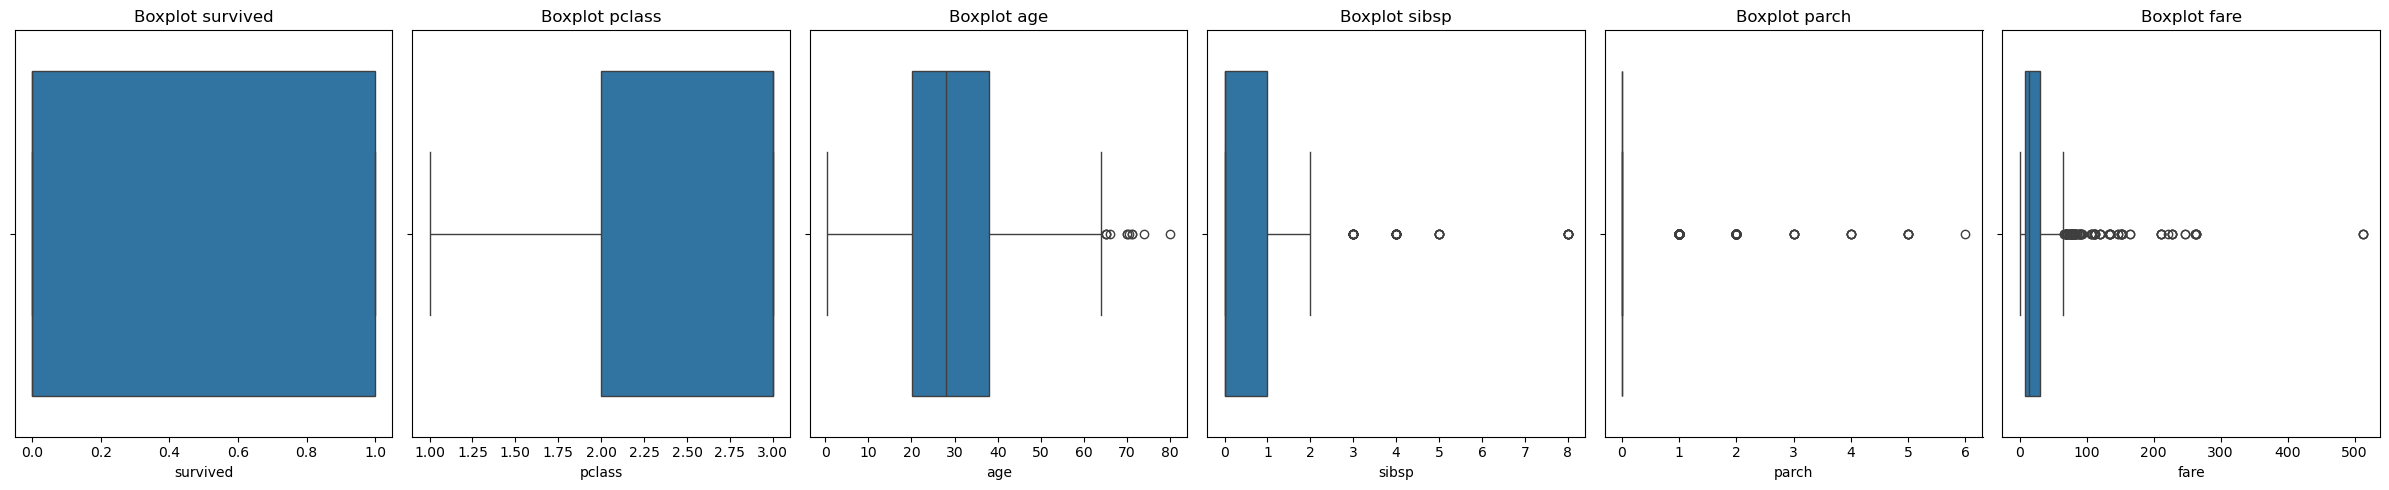

In [3]:
# cek outlier
import seaborn as sns
import matplotlib.pyplot as plt

# ambil semau kolom numerik otomatis
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns   

plt.figure(figsize=(len(numeric_cols) * 4, 5))

for i, col in enumerate(numeric_cols):
    plt.subplot(1, len(numeric_cols), i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')

plt.tight_layout()
plt.show()

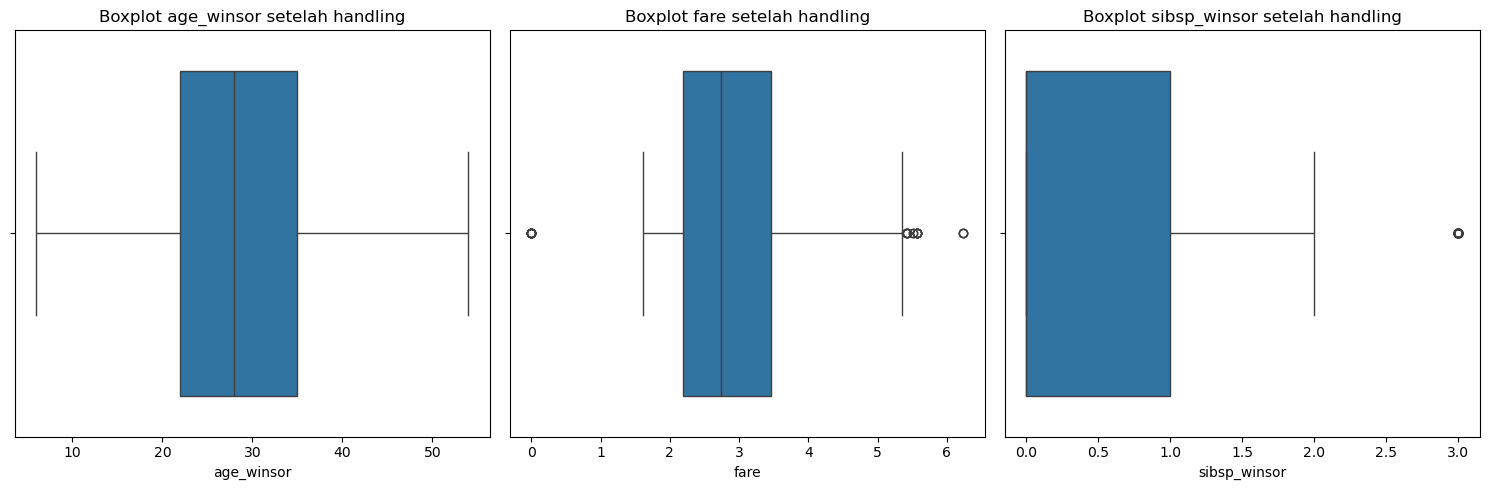

In [ ]:
# handle Outlier
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Imputasi missing values
imputer_median = SimpleImputer(strategy='median')
imputer_mean = SimpleImputer(strategy='mean')

# Handle missing values untuk kolom numerik
df['age'] = imputer_median.fit_transform(df[['age']])
df['fare'] = imputer_mean.fit_transform(df[['fare']])
df['sibsp'] = imputer_median.fit_transform(df[['sibsp']])

# Winsorizing untuk mengurangi pengaruh outlier
df['age_winsor'] = winsorize(df['age'], limits=[0.05, 0.05])  # 5% bawah dan atas
df['sibsp_winsor'] = winsorize(df['sibsp'], limits=[0.05, 0.05])

# Transformasi log untuk normalisasi distribusi 'fare'
df['fare'] = np.log1p(df['fare'])  # log(1 + x), aman untuk nilai 0

# Visualisasi distribusi setelah handling outlier
plt.figure(figsize=(15, 5))
for i, col in enumerate(['age_winsor', 'fare', 'sibsp_winsor']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col} setelah handling')

plt.tight_layout()
plt.show()


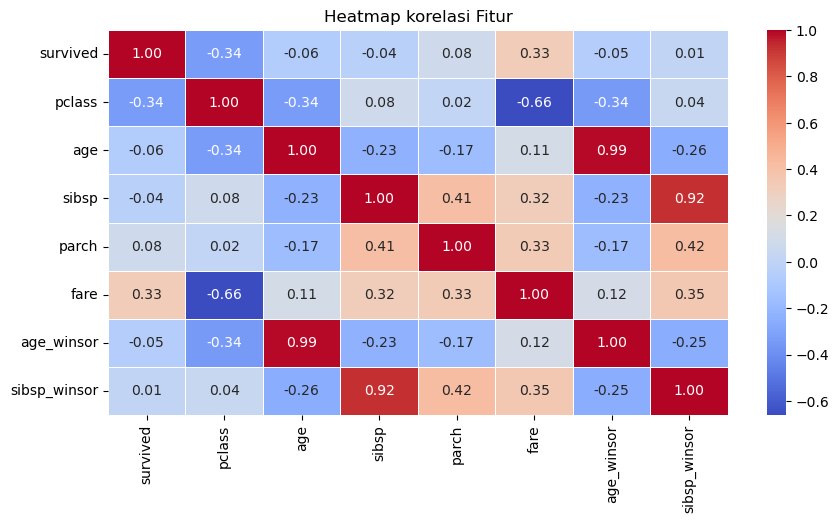

In [5]:
# cek korelasi 
import seaborn as sns
import matplotlib.pyplot

# filter hanya kolom numerik
df_numeric = df.select_dtypes(include=['number'])

# cek korelasi

plt.figure(figsize=(10, 5))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap korelasi Fitur')
plt.show()

In [6]:
# cek tipe data tiap kolom
print(df.dtypes)

survived           int64
pclass             int64
sex               object
age              float64
sibsp            float64
parch              int64
fare             float64
embarked          object
class           category
who               object
adult_male          bool
deck            category
embark_town       object
alive             object
alone               bool
age_winsor       float64
sibsp_winsor     float64
dtype: object


In [12]:
# preprocessing

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.decomposition import PCA

# handling missing values
X = df.drop(columns=['survived', 'alive'])
y = df['survived']

X['age'] = X['age'].fillna(X['age'].mean())

cat_cols = ['embarked', 'embark_town', 'deck']
for col in cat_cols:
    mode = X[col].mode()[0]
    X[col] = X[col].fillna(mode)

# encoding data kategorikal
labels_cols = ['sex', 'who']
le = LabelEncoder()
for col in labels_cols:
    X[col] = le.fit_transform(X[col])

one_hot_cols = ['embarked', 'class', 'deck', 'embark_town']
X = pd.get_dummies(X, columns=one_hot_cols, drop_first=True)

# scaling fitur numerik
num_cols = ['age', 'fare', 'sibsp', 'parch']
scaler = RobustScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# PCA setelah scaling
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# split dataset setelah PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [13]:
# Training Model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = KNeighborsClassifier(n_neighbors=10)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'Classification report : {classification_report(y_test, y_pred)}')
print(f'Confusion matrix :\n {confusion_matrix(y_test, y_pred)}')

Classification report :               precision    recall  f1-score   support

           0       0.81      0.94      0.87       105
           1       0.89      0.69      0.78        74

    accuracy                           0.84       179
   macro avg       0.85      0.82      0.83       179
weighted avg       0.85      0.84      0.83       179

Confusion matrix :
 [[99  6]
 [23 51]]


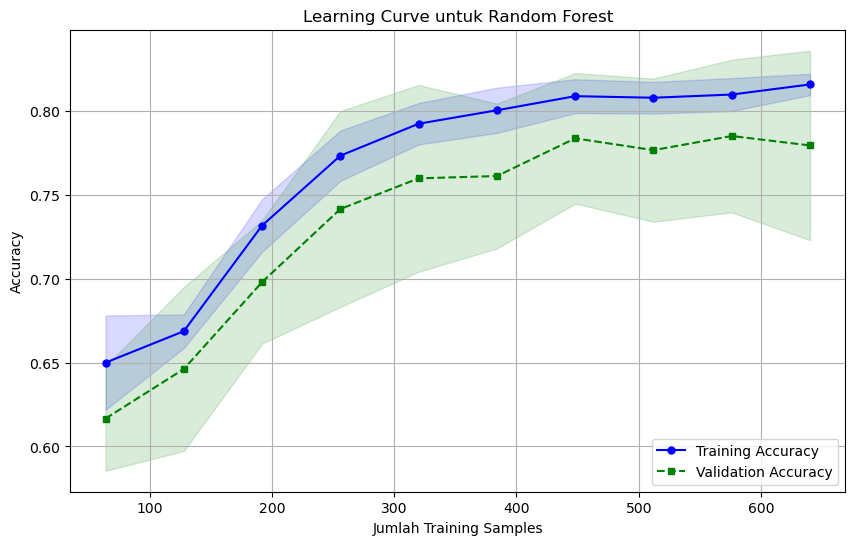

In [9]:
# learning_curve

from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Membuat learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

# Menghitung mean dan std untuk plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Jumlah Training Samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve untuk Random Forest')
plt.legend(loc='lower right')
plt.show()
